Sentiment Scope: Leveraging LSTM for Hotel Review Sentiment Analysis

---






**IMPORTING LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SimpleRNN, LSTM, GRU
from tensorflow.keras import regularizers
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

**READING DATA**

In [ ]:
df = pd.read_csv('/content/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


**Overvew of Dataset**

In [ ]:
# No. of rows & Columns and datatypes

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
# Null Values

df.isnull().sum()

Review    0
Rating    0
dtype: int64

# Wordcloud

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(width=800,
               height=500,
               background_color='white',
               min_font_size=10)

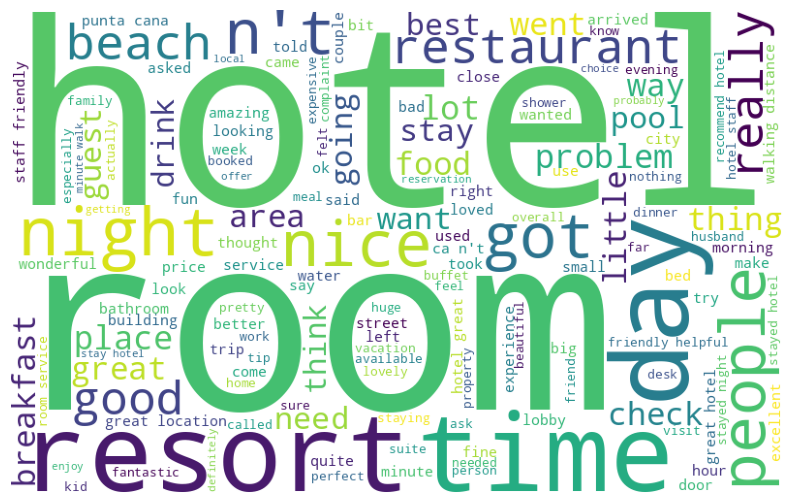

In [ ]:
wc.generate(''.join(df['Review']))
plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis('off')
plt.show()

# Data Visualization

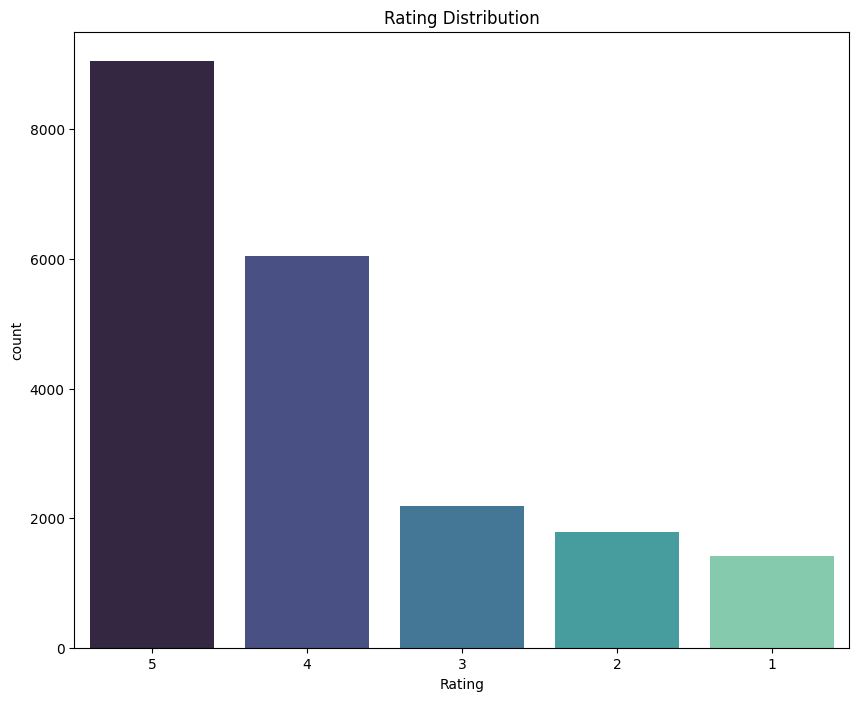

In [ ]:
plt.figure(figsize=(10,8))

sns.countplot(data=df,
              x='Rating',
              palette="mako",
              order = df['Rating'].value_counts().index)

plt.title('Rating Distribution')

plt.show()

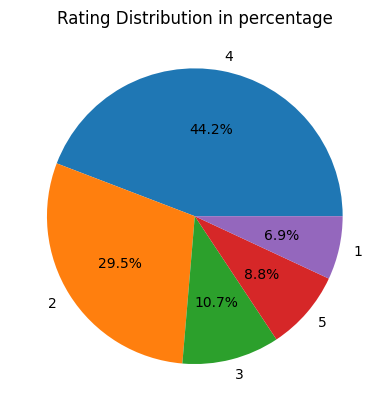

In [ ]:
plt.pie(df['Rating'].value_counts(), labels=df['Rating'].unique().tolist(), autopct='%1.1f%%')
plt.title('Rating Distribution in percentage')
plt.show()

# Text Preprocessing

In [ ]:
# Let's change the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Bad'

In [ ]:
df['Rating'] = df['Rating'].apply(rating)

In [ ]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,Good
1,ok nothing special charge diamond member hilto...,Bad
2,nice rooms not 4* experience hotel monaco seat...,Netral
3,"unique, great stay, wonderful time hotel monac...",Good
4,"great stay great stay, went seahawk game aweso...",Good


In [ ]:
# Creating a Function clean_text for text preprocessing

def clean_text(text):
    stop = stopwords.words('english')
    punc = list(punctuation)
    bad_tokens = stop + punc
    lemma = WordNetLemmatizer()
    tokens = word_tokenize(text)
    word_tokens = [t for t in tokens if t.isalpha()]
    clean_token = [lemma.lemmatize(t.lower()) for t in word_tokens if t not in bad_tokens]
    return " ".join(clean_token)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Applying text preprocessing methods to df['Review']

df['Review'] = df['Review'].apply(clean_text)

In [ ]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,Good
1,ok nothing special charge diamond member hilto...,Bad
2,nice room experience hotel monaco seattle good...,Netral
3,unique great stay wonderful time hotel monaco ...,Good
4,great stay great stay went seahawk game awesom...,Good


# Splitting target and feature columns

In [ ]:
x = df['Review']
y = df['Rating']

In [ ]:
# Train Test Split

from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,random_state=1,test_size=0.2)

# Checking No. of words in each sentence of Review column

In [ ]:
sent_len = []
for sent in df['Review']:
    sent_len.append(len(word_tokenize(sent)))
df['sent_len'] = sent_len
df.head()

,Review,Rating,sent_len
0,nice hotel expensive parking got good deal sta...,Good,79
1,ok nothing special charge diamond member hilto...,Bad,223
2,nice room experience hotel monaco seattle good...,Netral,183
3,unique great stay wonderful time hotel monaco ...,Good,82
4,great stay great stay went seahawk game awesom...,Good,171


In [ ]:
# Checking the reveiw with max no. of words

max(sent_len)

1752

In [ ]:
pd.set_option('display.max_rows', None)
print(df['sent_len'].value_counts())

sent_len
48      233
45      231
47      228
54      225
50      223
46      220
44      220
39      218
43      216
36      213
37      213
52      212
32      212
57      211
38      210
60      209
30      208
42      208
40      208
56      207
61      206
58      205
34      204
35      203
53      202
55      201
67      200
31      198
49      198
63      197
41      196
51      194
29      192
33      184
69      183
65      182
66      180
59      179
62      179
68      177
64      175
25      175
70      171
73      171
71      169
75      168
28      167
26      163
27      162
79      161
76      160
77      160
83      159
24      158
78      156
74      155
72      150
82      150
81      149
92      139
88      135
91      133
23      131
89      129
20      128
85      125
80      123
94      122
21      119
86      119
22      114
97      114
84      113
87      112
90      107
93      106
18      105
98      104
105     104
96      102
103     100
95      100
100    

In [ ]:
# Removing 5% of data beacuse not all sentence length is 39 which is our max sent_len.
np.quantile(sent_len,0.95)

246.0

In [ ]:
max_len = 246

# Tokenization, Vectorization & Padding Sequence

In [ ]:
# Word tokenize on basis of spacing between each words

tok = Tokenizer(char_level=False,split=' ')
tok.fit_on_texts(xtrain)

In [ ]:
# Index of all unique tokenized words

tok.index_word

{1: 'hotel',
 2: 'room',
 3: 'great',
 4: 'good',
 5: 'staff',
 6: 'stay',
 7: 'night',
 8: 'day',
 9: 'time',
 10: 'nice',
 11: 'location',
 12: 'stayed',
 13: 'service',
 14: 'restaurant',
 15: 'beach',
 16: 'breakfast',
 17: 'clean',
 18: 'place',
 19: 'food',
 20: 'resort',
 21: 'like',
 22: 'pool',
 23: 'really',
 24: 'bed',
 25: 'area',
 26: 'people',
 27: 'friendly',
 28: 'small',
 29: 'bar',
 30: 'walk',
 31: 'got',
 32: 'little',
 33: 'excellent',
 34: 'view',
 35: 'bathroom',
 36: 'best',
 37: 'minute',
 38: 'helpful',
 39: 'trip',
 40: 'floor',
 41: 'water',
 42: 'lot',
 43: 'recommend',
 44: 'price',
 45: 'make',
 46: 'review',
 47: 'beautiful',
 48: 'went',
 49: 'thing',
 50: 'comfortable',
 51: 'desk',
 52: 'problem',
 53: 'want',
 54: 'right',
 55: 'way',
 56: 'drink',
 57: 'city',
 58: 'free',
 59: 'wonderful',
 60: 'better',
 61: 'street',
 62: 'away',
 63: 'buffet',
 64: 'bit',
 65: 'say',
 66: 'booked',
 67: 'large',
 68: 'need',
 69: 'hour',
 70: 'quite',
 71: 'new'

In [ ]:
# Total No. of Unique words inour dataset

vocab_len = len(tok.index_word)
vocab_len

38416

In [ ]:
# Putting all index/unique id of each words in a sequence according to the data

sequences_train = tok.texts_to_sequences(xtrain)
sequences_train

[[483,
  2004,
  72,
  483,
  2004,
  1,
  12,
  457,
  13,
  2892,
  100,
  72,
  5,
  943,
  963,
  4696,
  289,
  12427,
  14817,
  14,
  5,
  482,
  5,
  733,
  5,
  4697,
  2893,
  374,
  13,
  887,
  21,
  453,
  2965,
  757,
  4166,
  264,
  4245,
  1912],
 [10,
  1,
  6,
  10,
  2,
  67,
  35,
  17,
  50,
  102,
  392,
  404,
  102,
  147,
  710,
  40,
  1650,
  47,
  40,
  9027,
  5,
  103,
  2,
  40,
  9027,
  204,
  31,
  187,
  5,
  38,
  21,
  358,
  1,
  5,
  836,
  19449,
  1725,
  2028,
  307,
  6698,
  426,
  3544,
  31,
  148,
  587,
  887,
  2134,
  19450,
  7915,
  59,
  19,
  214,
  99,
  1096,
  14,
  7,
  1005,
  117,
  1304,
  1705,
  1,
  922,
  7,
  132,
  25,
  601,
  6699,
  189,
  7033,
  14,
  34,
  1096,
  804,
  43,
  3,
  14818,
  8,
  39,
  3797,
  9028,
  5763,
  5058,
  145,
  135,
  340,
  1,
  6],
 [572,
  20,
  175,
  74,
  572,
  840,
  20,
  1,
  1507,
  47,
  837,
  15,
  688,
  1464,
  99,
  1813,
  3038,
  8,
  8,
  678,
  505,
  2005,
  1781

In [ ]:
# Padding Sequence

sequence_matrix_train = sequence.pad_sequences(sequences_train,maxlen=max_len)
sequence_matrix_train

array([[    0,     0,     0, ...,   264,  4245,  1912],
       [    0,     0,     0, ...,   340,     1,     6],
       [    0,     0,     0, ...,     4,  1795,   588],
       ...,
       [    0,     0,     0, ...,     2, 38416,   268],
       [    0,     0,     0, ...,  1087,    43,     1],
       [    0,     0,     0, ...,  2819,  6535,   105]], dtype=int32)

In [ ]:
# One hot encoding the label
lb = LabelEncoder()
ytrain = lb.fit_transform(ytrain)
ytest = lb.transform(ytest)

# Model Building (Neural Network)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_len+1,500,input_length=max_len,mask_zero=True))                                                  # Embedding
#model.add(SimpleRNN(32,activation='tanh'))                                                                                # RNN Layer
model.add(LSTM(16,activation='tanh'))                                                                                      # LSTM Layer
#model.add(GRU(64,activation='tanh'))                                                                                      # GRU Layer
model.add(Dense(8,activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))    # Hidden Layer
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))                                                                                   # Output Layer

In [ ]:
# Summary of our model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 246, 500)          19208500  
                                                                 
 lstm (LSTM)                 (None, 16)                33088     
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 19241751 (73.40 MB)
Trainable params: 19241751 (73.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile our Model

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Training our model

trained_model = model.fit(sequence_matrix_train,ytrain,epochs=20)

Epoch 1/20
513/513 [==============================] - 330s 631ms/step - loss: 0.8853 - accuracy: 0.7238
Epoch 2/20
513/513 [==============================] - 322s 628ms/step - loss: 0.6623 - accuracy: 0.7732
Epoch 3/20
513/513 [==============================] - 321s 625ms/step - loss: 0.5350 - accuracy: 0.8015
Epoch 4/20
513/513 [==============================] - 318s 620ms/step - loss: 0.4752 - accuracy: 0.8175
Epoch 5/20
513/513 [==============================] - 318s 621ms/step - loss: 0.4276 - accuracy: 0.8300
Epoch 6/20
513/513 [==============================] - 319s 622ms/step - loss: 0.3898 - accuracy: 0.8314
Epoch 7/20
513/513 [==============================] - 321s 625ms/step - loss: 0.3572 - accuracy: 0.8436
Epoch 8/20
513/513 [==============================] - 378s 737ms/step - loss: 0.3368 - accuracy: 0.8679
Epoch 9/20
513/513 [==============================] - 371s 723ms/step - loss: 0.3147 - accuracy: 0.8738
Epoch 10/20
513/513 [==============================] - 370s 720m

In [ ]:
# Giving each unique tokens/word a unique Id or index and the apply padding sequence

sequence_matrix_test = sequence.pad_sequences(tok.texts_to_sequences(xtest),maxlen=max_len)

In [ ]:
# Checking Training and Testing loss

print('Training_loss :',model.evaluate(sequence_matrix_train,ytrain))
print('Testing_loss :',model.evaluate(sequence_matrix_test,ytest))

513/513 [==============================] - 22s 39ms/step - loss: 0.1353 - accuracy: 0.9566
Training_loss : [0.1352778673171997, 0.95656418800354]
129/129 [==============================] - 6s 45ms/step - loss: 0.8468 - accuracy: 0.8102
Testing_loss : [0.8467593193054199, 0.8101975917816162]


In [ ]:
# Testing our model

Y_pred = model.predict(sequence_matrix_test)''
print(np.round(Y_pred,3))

129/129 [==============================] - 6s 36ms/step
[[0.    1.    0.   ]
 [0.279 0.203 0.518]
 [0.    0.999 0.001]
 ...
 [0.    1.    0.   ]
 [0.    1.    0.   ]
 [0.509 0.034 0.458]]


In [ ]:
# List comprehension to select class with highest probability

Y_pred = [np.argmax(i) for i in Y_pred]
Y_pred

[1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 1,
 0,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(ytest,Y_pred))
print(confusion_matrix(ytest,Y_pred))

              precision    recall  f1-score   support

           0       0.62      0.77      0.69       649
           1       0.91      0.90      0.91      3042
           2       0.27      0.19      0.22       408

    accuracy                           0.81      4099
   macro avg       0.60      0.62      0.61      4099
weighted avg       0.80      0.81      0.80      4099

[[ 499   85   65]
 [ 153 2744  145]
 [ 151  179   78]]


# Prediction

In [ ]:
def dl_predict(text):
    cleantext = clean_text(text)
    seq = tok.texts_to_sequences([cleantext])
    padded = sequence.pad_sequences(seq)

    pred = model.predict(padded)
    # Get the index of the maximum value in the prediction array
    predicted_index = np.argmax(pred, axis=1)[0]
    # Get the label name using the index
    result = lb.classes_[predicted_index]

    return result

In [ ]:
text = 'Such a comfy place to stay with the loved one'

print('Prediction using DNN: {}'.format(dl_predict(text)))

1/1 [==============================] - 1s 1s/step
Prediction using DNN: Good


In [ ]:
text3 = 'Had a bad experience but scenery was good'

print('Prediction using DNN: {}'.format(dl_predict(text3)))

1/1 [==============================] - 0s 21ms/step
Prediction using DNN: Netral
